In [20]:
import os
import json
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta

from google.cloud import bigquery
from google.oauth2 import service_account

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#matplotlib 패키지 한글 깨짐 처리 시작
plt.rc('font', family='AppleGothic') #맥

df = pd.read_csv('ga4_data.csv')

/var/folders/mk/p5y6cznx60788rys6_dnljxm0000gn/T/ipykernel_70854/64509669.py:23: DtypeWarning:

Columns (1,29) have mixed types. Specify dtype option on import or set low_memory=False.



In [21]:
# 전처리 
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'])
df['totals_totalTransactionRevenue'] = df['totals_totalTransactionRevenue'].fillna(0)
df['hits_transaction_transactionRevenue'] = df['hits_transaction_transactionRevenue'].fillna(0)
df['fullVisitorId'] = df['fullVisitorId'].astype(str)

def pad_with_zeros(string):
    """
    문자열의 길이가 19이 될 때까지 앞에 0을 추가하는 함수
    """
    # 문자열의 길이를 세기
    length = len(string)
    
    # 문자열의 길이가 20이 될 때까지 앞에 0을 추가
    while length < 19:
        string = '0' + string
        length += 1
    
    return string

df['fullVisitorId'] = df['fullVisitorId'].apply(pad_with_zeros)

df.visitStartTime = (df.visitStartTime - timedelta(hours=8))
# df = df.assign(month = df.visitStartTime.dt.strftime('%Y-%m'))
# df = df.assign(date = df.visitStartTime.dt.strftime('%m-%d'))
# df = df.assign(day_name = df.visitStartTime.dt.weekday)

In [22]:
구매고객 = df[df['totals_totalTransactionRevenue'] != 0]['fullVisitorId'].unique()
purchase = df[df['fullVisitorId'].isin(구매고객)]

user_visit_Cnt = purchase.groupby('fullVisitorId')['visitId'].nunique().to_frame()
user_buy_total_Cnt = pd.DataFrame(purchase[purchase['totals_totalTransactionRevenue'] != 0].groupby('fullVisitorId')['visitId'].nunique())
user_buy_total_Revenue = purchase[purchase['hits_transaction_transactionRevenue'] > 0].groupby('fullVisitorId')[['totals_totalTransactionRevenue']].agg('sum')

vvip_VFM = user_visit_Cnt.merge(user_buy_total_Cnt, how='inner', on='fullVisitorId') # V : visit Count
vvip_VFM = vvip_VFM.merge(user_buy_total_Revenue, how='inner', on='fullVisitorId') 

vvip_VFM = vvip_VFM.rename(columns={'visitId_x' : 'visit_Cnt'})
vvip_VFM = vvip_VFM.rename(columns={'visitId_y' : 'buy_Cnt'})
vvip_VFM = vvip_VFM.rename(columns={'totals_totalTransactionRevenue' : 'total_Revenue'})

vvip_VFM

,visit_Cnt,buy_Cnt,total_Revenue
fullVisitorId,,,
0000213131142648941,1,1,39.59
0000435324061339869,3,1,46.79
0000562678147042735,2,1,316.62
0000585708896049892,1,1,45.97
0000852801263780322,1,1,80.00
...,...,...,...
9991633376050115277,1,1,35.59
9994767073213036303,5,1,140.32
9997409246962677759,1,1,40.36


In [23]:
# # RFM -> VFM
# # 방문빈도 : 구매했던 안했던 visitId count
# # 구매건수 : revunue 찍힌 visitId 만 count
# # 총매출 : Total Revenue

# # 방문 건수 계산 :
# user_visit_Cnt = df.groupby('fullVisitorId')['visitId'].nunique().to_frame()

# # 구매건수 계산 : Buy Count
# user_buy_total_Cnt = df[df['totals_totalTransactionRevenue'] != 0].groupby('fullVisitorId')['visitId'].nunique()

# # 총매출 : 
# user_buy_total_Revenue = df[df['hits_transaction_transactionRevenue'] > 0].groupby('fullVisitorId')[['totals_totalTransactionRevenue']].agg('sum').sort_values('totals_totalTransactionRevenue')

In [24]:
# # 구매고객 전용
# vvip_VFM = user_visit_Cnt.merge(user_buy_total_Cnt, how='inner', on='fullVisitorId') # V : visit Count
# vvip_VFM = vvip_VFM.rename(columns={'visitId' : 'visit_Cnt'})
# vvip_VFM = vvip_VFM.rename(columns={'totals_totalTransactionRevenue' : 'buy_Cnt'})
# vvip_VFM = vvip_VFM.merge(user_buy_total_Revenue, how='inner', on='fullVisitorId') 
# vvip_VFM = vvip_VFM.rename(columns={'totals_totalTransactionRevenue' : 'total_Revenue'})

# vvip_VFM

In [25]:
# 이상치 제거
# vvip_VFM = vvip_VFM[vvip_VFM['total_Revenue'] <= 25000]

K-means 는 다음 조건에서 최상의 결과를 제공합니다.

1. 데이터 분포가 편향되지 않음
2. 데이터가 표준화되어 있습니다(즉, 평균은 0, 표준편차는 1).

# 스케일링 및 정규화

In [26]:
# # 히스토그램 그리기
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# columns = ['visit_Cnt','buy_Cnt','total_Revenue']
# for i, column in enumerate(columns):
#     axs[i].hist(vvip_VFM[column], bins=30)
#     axs[i].set_title(f"{column}")

In [27]:
# vvip_VFM = np.log(vvip_VFM + 1)

# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# columns = ['visit_Cnt','buy_Cnt','total_Revenue']
# for i, column in enumerate(columns):
#     axs[i].hist(vvip_VFM[column], bins=30)
#     axs[i].set_title(f"{column}")

In [28]:
# #스케일링
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# temp = vvip_VFM.reset_index()
# scaler.fit(vvip_VFM)
# vvip_VFM = scaler.transform(vvip_VFM)
# vvip_VFM = pd.DataFrame(vvip_VFM, columns = ['visit_Cnt','buy_Cnt','total_Revenue'])
# vvip_VFM.index = temp['fullVisitorId']
# vvip_VFM.head(10)

# 플롯 시각화

In [41]:
import plotly.express as px

fig = px.scatter_3d(vvip_VFM, 
                  x='visit_Cnt', y='buy_Cnt', z='total_Revenue')
# fig.update_layout(yaxis={'visible': False, 'showticklabels': False})
fig.show()

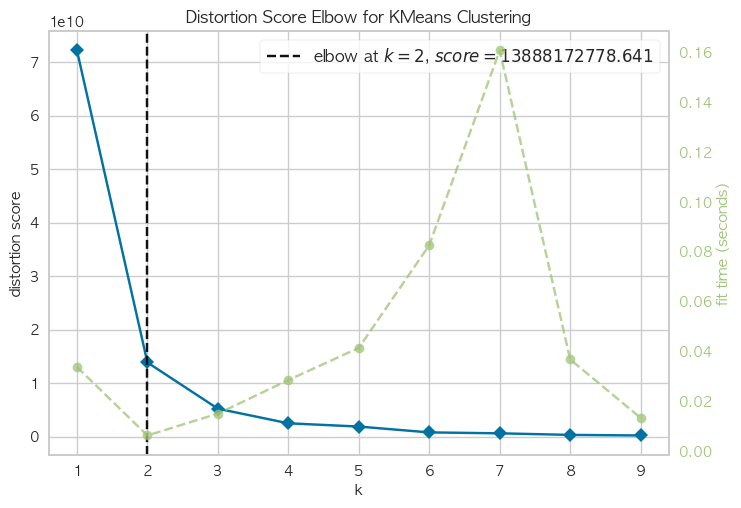

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
# !pip install yellowbrick
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()

visualizer = KElbowVisualizer(model, k=(1,10), timings=True)
visualizer.fit(vvip_VFM)
visualizer.show()

In [31]:
# # 최적의 클러스터 확인 : 실루엣 계수
# from sklearn.metrics import silhouette_score

# silhouette_scores = []
# for k in range(2, 11):
#     kmeans = KMeans(n_clusters=k, random_state=0)
#     kmeans.fit(vvip_VFM)
#     score = silhouette_score(vvip_VFM, kmeans.labels_)
#     silhouette_scores.append(score)

# # 실루엣 분석 그래프 그리기
# plt.plot(range(2, 11), silhouette_scores, marker='o')

In [32]:
# K means clustering 진행
from sklearn.cluster import KMeans

def clustering(k, df):
    km = KMeans(n_clusters=k)
    km.fit(df)
    # centroids = km.cluster_centers_ : 중심값

    # 클러스터 라벨 컬럼 생성
    df['labels'] = km.labels_
    # vvip_VFM_cluster['labels'] = km.predict(vvip_VFM_cluster) : 예측값 ver

    # scatter 시각화
    import seaborn as sns
    sns.scatterplot(x='buy_Cnt', y='total_Revenue', hue='labels', data=df)

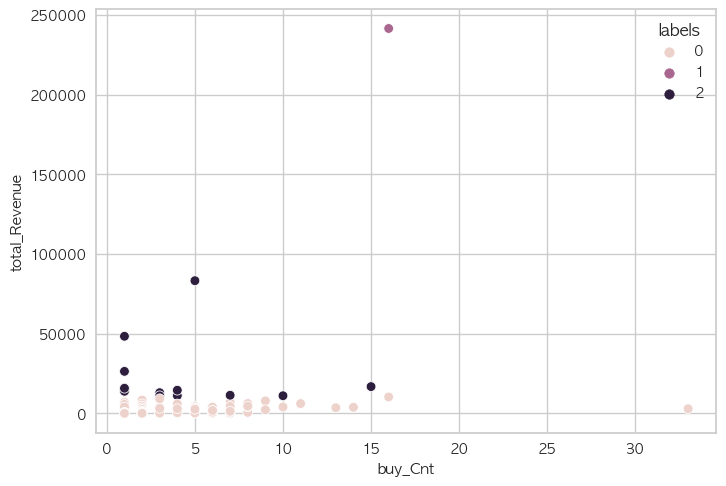

In [33]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(vvip_VFM)

pca_transformed = pd.DataFrame(pca_transformed, columns=(['PCA_x', 'PCA_y']))
pca_transformed

clustering(3, vvip_VFM)

In [34]:
import plotly.express as px

fig = px.scatter_3d(vvip_VFM, 
                  x='visit_Cnt', y='buy_Cnt', z='total_Revenue')
fig.show()

<Axes: xlabel='Metric', ylabel='Value'>

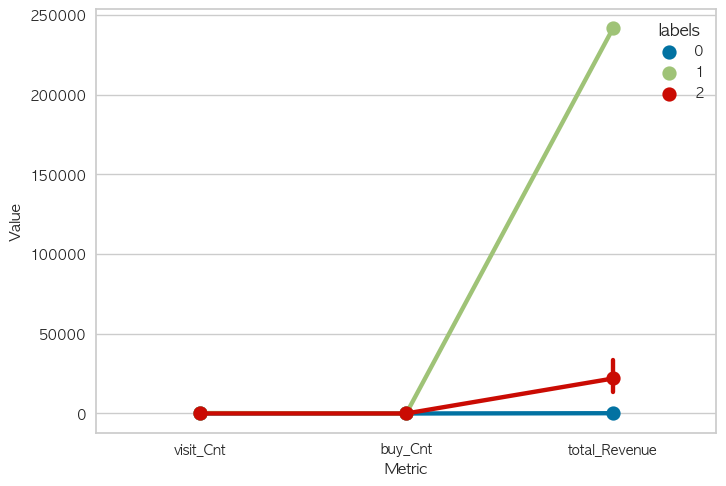

In [35]:
# snake plot

# Melt data into long format
df_melt = pd.melt(vvip_VFM.reset_index(), 
                        id_vars=['fullVisitorId', 'labels'],
                        value_vars=['visit_Cnt', 'buy_Cnt', 'total_Revenue'], 
                        var_name='Metric', 
                        value_name='Value')
plt.xlabel('Metric')
plt.ylabel('Value')
sns.pointplot(data=df_melt, x='Metric', y='Value', hue='labels')
    


In [36]:
vvip_VFM.groupby(['labels']).agg({
        'visit_Cnt': 'mean',
        'buy_Cnt': 'mean',
        'total_Revenue': ['mean', 'count']
}).round(0)

visit_Cnt buy_Cnt total_Revenue      
            mean    mean          mean count
labels                                      
0            4.0     1.0         161.0  9406
1          275.0    16.0      241619.0     1
2           15.0     4.0       21950.0    14

In [37]:
vvip_VFM

,visit_Cnt,buy_Cnt,total_Revenue,labels
fullVisitorId,,,,
0000213131142648941,1,1,39.59,0
0000435324061339869,3,1,46.79,0
0000562678147042735,2,1,316.62,0
0000585708896049892,1,1,45.97,0
0000852801263780322,1,1,80.00,0
...,...,...,...,...
9991633376050115277,1,1,35.59,0
9994767073213036303,5,1,140.32,0
9997409246962677759,1,1,40.36,0


<Axes: xlabel='Metric', ylabel='Value'>

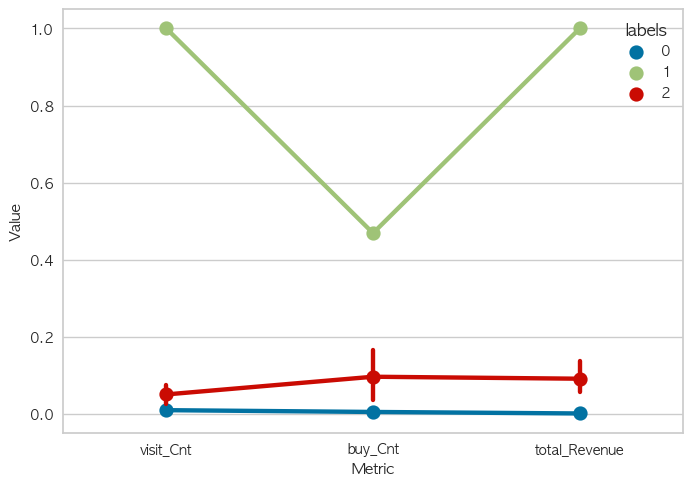

In [38]:
# 스네이크 플롯 시각화 할때만 정규화하기 (잘보이기 위해서)
from sklearn.preprocessing import MinMaxScaler
# MinMaxScaler 객체를 생성합니다.
minmax_scaler = MinMaxScaler()

# fit_transform()을 사용해서 학습과 스케일링을 한 번에 적용합니다.

minmax = minmax_scaler.fit_transform(vvip_VFM)
minmax = pd.DataFrame(minmax, index=vvip_VFM.index, columns=vvip_VFM.columns)
minmax['labels'] = vvip_VFM['labels']

# Melt data into long format
df_melt = pd.melt(minmax.reset_index(), 
                        id_vars=['fullVisitorId', 'labels'],
                        value_vars=['visit_Cnt', 'buy_Cnt', 'total_Revenue'], 
                        var_name='Metric', 
                        value_name='Value')
plt.xlabel('Metric')
plt.ylabel('Value')
sns.pointplot(data=df_melt, x='Metric', y='Value', hue='labels')